Сверточная нейросеть классификации входящих и выходящих пассажиров автобуса.

Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 93% на проверочной выборке

### Загрузка данных


In [ ]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image 

# Для отрисовки графиков
import matplotlib.pyplot as plt 

# Для генерации случайных чисел 
import random 

# Библиотека работы с массивами
import numpy as np 

# Для работы с файлами 
import os 

# импортируем модуль для загрузки данных
import gdown 

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam 

# модуль для отсчета времени
import time 

In [ ]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива 
gdown.download('https://storage.googleapis.com/terra_ai/DataSets/bus.zip', None, quiet=True) 

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus  

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus/' 

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH) 

replace /content/bus/getting_off/00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


['getting_off', 'entering']

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['entering', 'getting_off']


In [ ]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

entering : ['04278.jpg', '05021.jpg', '02538.jpg', '05759.jpg', '03416.jpg', '03626.jpg', '00936.jpg', '04130.jpg', '03742.jpg', '00386.jpg', '00227.jpg', '04732.jpg', '00933.jpg', '01813.jpg', '01919.jpg', '01185.jpg', '05912.jpg', '00384.jpg', '00846.jpg', '00173.jpg', '03761.jpg', '03566.jpg', '04322.jpg', '04750.jpg', '03787.jpg', '02500.jpg', '03549.jpg', '05728.jpg', '03759.jpg', '01905.jpg', '00947.jpg', '02528.jpg', '04801.jpg', '04828.jpg', '02051.jpg', '02929.jpg', '00784.jpg', '01176.jpg', '02543.jpg', '02979.jpg', '03807.jpg', '02823.jpg', '01634.jpg', '01800.jpg', '01309.jpg', '03729.jpg', '04705.jpg', '05350.jpg', '04466.jpg', '04383.jpg', '03795.jpg', '05765.jpg', '05093.jpg', '05214.jpg', '02560.jpg', '05781.jpg', '01936.jpg', '04171.jpg', '03660.jpg', '01829.jpg', '03471.jpg', '03590.jpg', '02902.jpg', '06435.jpg', '01324.jpg', '04347.jpg', '04065.jpg', '01147.jpg', '03644.jpg', '03067.jpg', '02465.jpg', '03622.jpg', '04413.jpg', '01922.jpg', '00629.jpg', '04616.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

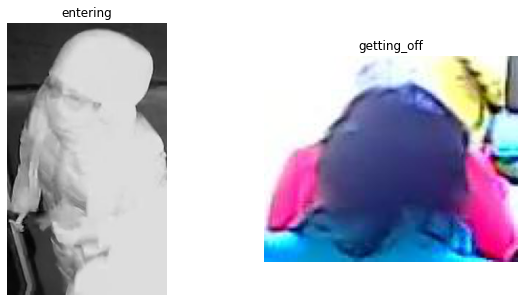

In [ ]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path)) 
    
    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))  
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [ ]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса entering составляет 6485 фото
Размер класса getting_off составляет 2596 фото

Общий размер базы для обучения: 9081


In [ ]:
img_shape = []
for file_name in data_files:
    # Открытие и смена размера изображения
    img = Image.open(file_name)#.resize((IMG_WIDTH, IMG_HEIGHT)) 
    img_np = np.array(img)                # Перевод в numpy-массив
    img_shape.append(img_np.shape)
img_shape=np.array(img_shape)
img_mean=img_shape.mean(axis=0)
img_std=img_shape.std(axis=0)

img_mean_x=img_mean[1]
img_mean_y=img_mean[0]
print("Mean=",img_mean,"STD=",img_std,"Mean/Std=",img_std/img_mean)

Mean= [342.14436736 207.40942627   3.        ] STD= [139.04571477  82.60373159   0.        ] Mean/Std= [0.40639487 0.39826411 0.        ]


Поменяем размеры картинок и создадим выборки.

In [ ]:



IMG_WIDTH=int(img_mean_x/2)-int(img_mean_x/2)%2
IMG_HEIGHT=int(img_mean_y/2)-int(img_mean_y/2)%2
x_train = []
x_test = []
x_val = []
y_train = []
y_test = []
y_val = []

for file_name in data_files:
    # Открытие и смена размера изображения
    img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT)) 
    img_np = np.array(img)                # Перевод в numpy-массив
    x_train.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку
x_train=np.array(x_train)
y_train=np.array(data_labels)
#scale
x_train=x_train/255


x_train, x_test, y_train, y_test = train_test_split(x_train, # ----------------- датасет с изображениям
                                                    y_train, # ----------------- датасет с метками
                                                    test_size = 0.1, # --- процент тестовых значений
                                                    shuffle=True, # ------ перемешивание
                                                    random_state=42) # --- 
x_train, x_val, y_train, y_val = train_test_split(x_train, # ----------------- датасет с изображениям
                                                    y_train, # ----------------- датасет с метками
                                                    test_size = 0.1, # --- процент тестовых значений
                                                    shuffle=True, # ------ перемешивание
                                                    random_state=42) # --- 
print(x_train.shape,x_test.shape,x_val.shape)
print(y_train.shape,y_test.shape,y_val.shape)



(7354, 170, 102, 3) (909, 170, 102, 3) (818, 170, 102, 3)
(7354,) (909,) (818,)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 170, 102, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 170, 102, 32)     128       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 170, 102, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 170, 102, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 85, 51, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 85, 51, 32)       

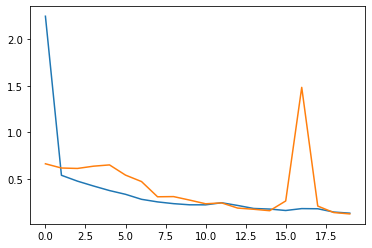

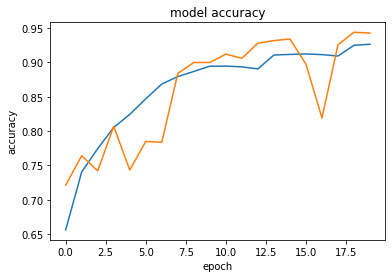

In [ ]:
# Создание модели последовательной архитектуры
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=np.shape(x_train[0])))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))
#model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
#model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Компиляция модели
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(x_train,y_train,validation_data=(x_val,y_val),shuffle=True,batch_size=128,epochs=20,verbose=2)
print(model.evaluate(x_test,y_test))
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss test')
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

94% на тестовой. Графики показывают функцию потерь.